# Dataset Visualization

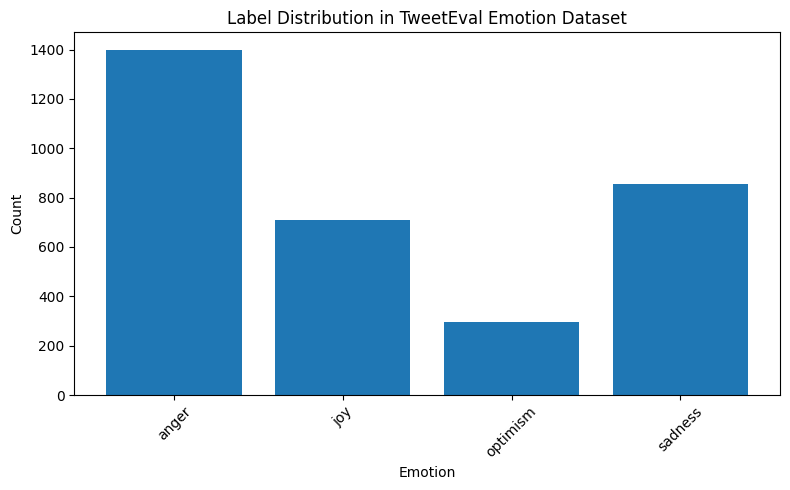

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

# Load a small portion for analysis
dataset = load_dataset("tweet_eval", "emotion", split="train")


label_names = dataset.features["label"].names
df = pd.DataFrame(dataset)
label_counts = df["label"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(label_names, label_counts)
plt.title("Label Distribution in TweetEval Emotion Dataset")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# My Model

🔹 Loading TweetEval data...


README.md:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/233k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/105k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/28.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3257 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1421 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/374 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

🔹 Preparing pairs...
🔹 Fine-tuning custom BERT encoder...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1 | Loss: 0.0180
Epoch 2 | Loss: 0.0177
Epoch 3 | Loss: 0.0177
Epoch 4 | Loss: 0.0177
Epoch 5 | Loss: 0.0177
🔹 Embedding entire dataset...
🔹 Clustering embeddings...
Cluster distribution: (array([0, 1, 2, 3], dtype=int32), array([ 473, 1121,  480, 1183]))
🔹 Evaluating clustering...
Silhouette Score: 0.1528
Davies-Bouldin Score: 1.6933
🔹 Visualizing with t-SNE...


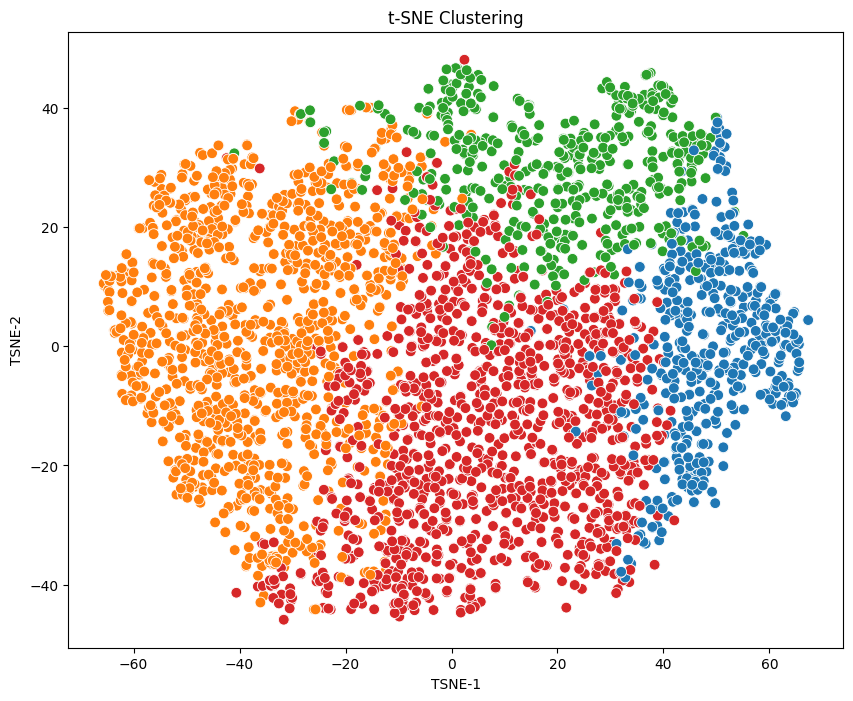

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Seed and device
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom NN: BERT + projection head
class CustomBERTEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.projection = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        return self.projection(pooled)

# Contrastive loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.5):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        return torch.mean((1 - label) * euclidean_distance**2 + 
                          (label) * torch.clamp(self.margin - euclidean_distance, min=0.0)**2)

# Prepare positive and negative pairs
def prepare_tweeteval_pairs(dataset, max_samples=10000):
    label_to_indices = {i: np.where(np.array(dataset["label"]) == i)[0] for i in range(4)}
    pairs, labels = [], []

    for _ in range(max_samples):
        label = np.random.randint(0, 4)
        if len(label_to_indices[label]) >= 2:
            a, b = np.random.choice(label_to_indices[label], 2, replace=False)
            c_label = (label + np.random.randint(1, 4)) % 4
            if len(label_to_indices[c_label]) > 0:
                c = np.random.choice(label_to_indices[c_label])
                pairs.append([dataset["text"][a], dataset["text"][b]])
                labels.append(1)
                pairs.append([dataset["text"][a], dataset["text"][c]])
                labels.append(0)
    return pairs, labels


# Fine-tune custom encoder
def fine_tune_custom_encoder(pairs, labels, tokenizer):
    model = CustomBERTEncoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    criterion = ContrastiveLoss()

    for epoch in range(5):
        model.train()
        epoch_loss = 0

        for i in range(0, len(pairs), 32):
            batch = pairs[i:i+32]
            batch_labels = torch.tensor(labels[i:i+32]).float().to(device)

            inputs_1 = tokenizer([p[0] for p in batch], return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            inputs_2 = tokenizer([p[1] for p in batch], return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

            embeddings_1 = model(inputs_1["input_ids"], inputs_1["attention_mask"])
            embeddings_2 = model(inputs_2["input_ids"], inputs_2["attention_mask"])

            loss = criterion(embeddings_1, embeddings_2, batch_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1} | Loss: {epoch_loss / len(pairs):.4f}")

    return model

# Embed dataset
def embed_dataset(dataset, tokenizer, model):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(dataset), 32):
            batch = dataset[i:i+32]
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            emb = model(inputs["input_ids"], inputs["attention_mask"]).cpu().numpy()
            embeddings.extend(emb)
    return np.array(embeddings)

# Clustering and evaluation
def run_kmeans(embeddings, n_clusters=8):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=100)
    labels = kmeans.fit_predict(embeddings)
    return labels

def evaluate_clustering(embeddings, labels):
    sil = silhouette_score(embeddings, labels)
    db = davies_bouldin_score(embeddings, labels)
    print(f"Silhouette Score: {sil:.4f}")
    print(f"Davies-Bouldin Score: {db:.4f}")

# Visualization
def visualize_clusters(embeddings, labels):
    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, palette="tab10", s=60, legend=None)
    plt.title("t-SNE Clustering")
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.show()

# Main pipeline
def main():
    print(" Loading TweetEval data...")
    dataset = load_dataset("tweet_eval", "emotion", split="train[:10000]")
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    print(" Preparing pairs...")
    pairs, pair_labels = prepare_tweeteval_pairs(dataset)

    print(" Fine-tuning custom BERT encoder...")
    model = fine_tune_custom_encoder(pairs, pair_labels, tokenizer)

    print(" Embedding entire dataset...")
    all_texts = [item["text"] for item in dataset]
    all_labels = [item["label"] for item in dataset]
    embeddings = embed_dataset(all_texts, tokenizer, model)

    print(" Clustering embeddings...")
    cluster_labels = run_kmeans(embeddings, n_clusters=4)

    print("Cluster distribution:", np.unique(cluster_labels, return_counts=True))

    print(" Evaluating clustering...")
    evaluate_clustering(embeddings, cluster_labels)

    print(" Visualizing with t-SNE...")
    visualize_clusters(embeddings, cluster_labels)
    torch.save(model.state_dict(), "/kaggle/working/contrastive_bert_model.pth")

    

main()



# Comparism with other methods

 Loading TweetEval Emotion dataset...
 Loading pre-trained Contrastive BERT model...
 Embedding texts using Contrastive BERT...
 Embedding texts using TF-IDF + PCA...
 Loading GloVe embeddings...
 Embedding texts using GloVe averages...

 Comparing clustering performance...

 Evaluating: Contrastive BERT
Silhouette Score: 0.1528
Davies-Bouldin Score: 1.6933

 Evaluating: TF-IDF + PCA
Silhouette Score: 0.0392
Davies-Bouldin Score: 3.8790

 Evaluating: GloVe Avg
Silhouette Score: 0.0664
Davies-Bouldin Score: 2.7207

 Visualizing clusters...


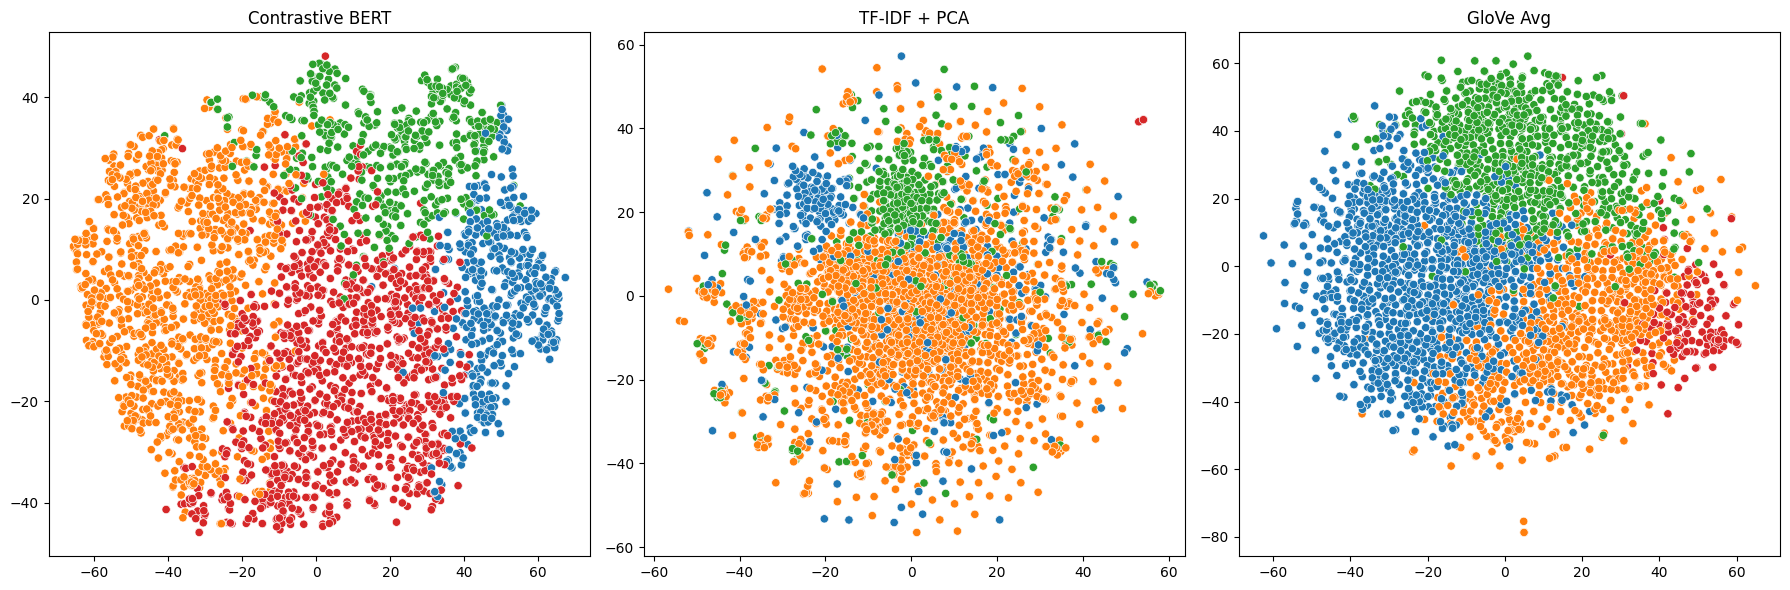

In [9]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Setup
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Custom contrastive BERT
class CustomBERTEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.projection = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        return self.projection(pooled)

# -------------------- DATA PREPARATION --------------------

def prepare_tweeteval_pairs(dataset, max_samples=10000):
    label_to_indices = {i: np.where(np.array(dataset["label"]) == i)[0] for i in range(4)}
    pairs, labels = [], []
    for _ in range(max_samples):
        label = np.random.randint(0, 4)
        if len(label_to_indices[label]) >= 2:
            a, b = np.random.choice(label_to_indices[label], 2, replace=False)
            c_label = (label + np.random.randint(1, 4)) % 4
            if len(label_to_indices[c_label]) > 0:
                c = np.random.choice(label_to_indices[c_label])
                pairs.append([dataset["text"][a], dataset["text"][b]])
                labels.append(1)
                pairs.append([dataset["text"][a], dataset["text"][c]])
                labels.append(0)
    return pairs, labels

def fine_tune_custom_encoder(pairs, labels, tokenizer):
    model = CustomBERTEncoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    criterion = ContrastiveLoss()

    for epoch in range(5):
        model.train()
        epoch_loss = 0
        for i in range(0, len(pairs), 32):
            batch = pairs[i:i+32]
            batch_labels = torch.tensor(labels[i:i+32]).float().to(device)

            inputs_1 = tokenizer([p[0] for p in batch], return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            inputs_2 = tokenizer([p[1] for p in batch], return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

            embeddings_1 = model(inputs_1["input_ids"], inputs_1["attention_mask"])
            embeddings_2 = model(inputs_2["input_ids"], inputs_2["attention_mask"])

            loss = criterion(embeddings_1, embeddings_2, batch_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        print(f"Epoch {epoch+1} | Loss: {epoch_loss / len(pairs):.4f}")
    return model

# -------------------- EMBEDDING METHODS --------------------

def embed_with_model(model, tokenizer, texts):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), 32):
            batch = texts[i:i+32]
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            emb = model(inputs["input_ids"], inputs["attention_mask"]).cpu().numpy()
            embeddings.extend(emb)
    return np.array(embeddings)

def tfidf_baseline(texts, n_components=128):
    vectorizer = TfidfVectorizer(max_features=5000)
    tfidf_vectors = vectorizer.fit_transform(texts)
    reduced = PCA(n_components=n_components, random_state=42).fit_transform(tfidf_vectors.toarray())
    return reduced

def load_glove_embeddings(path="/kaggle/input/globemebedding/glove.6B.100d.txt"):
    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype="float32")
            embeddings[word] = vector
    return embeddings

def average_glove_embeddings(texts, glove_dict, dim=100):
    embeddings = []
    for text in texts:
        words = text.lower().split()
        word_vectors = [glove_dict[word] for word in words if word in glove_dict]
        if word_vectors:
            avg = np.mean(word_vectors, axis=0)
        else:
            avg = np.zeros(dim)
        embeddings.append(avg)
    return np.array(embeddings)

# -------------------- CLUSTERING & EVALUATION --------------------

def run_kmeans(embeddings, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=100)
    labels = kmeans.fit_predict(embeddings)
    return labels

def evaluate_clustering(embeddings, labels):
    sil = silhouette_score(embeddings, labels)
    db = davies_bouldin_score(embeddings, labels)
    print(f"Silhouette Score: {sil:.4f}")
    print(f"Davies-Bouldin Score: {db:.4f}")

def compare_models(embeddings_dict):
    for name, emb in embeddings_dict.items():
        print(f"\n Evaluating: {name}")
        cluster_labels = run_kmeans(emb, n_clusters=4)
        evaluate_clustering(emb, cluster_labels)

def visualize_multiple(embeddings_dict):
    fig, axes = plt.subplots(1, len(embeddings_dict), figsize=(18, 6))
    for ax, (name, emb) in zip(axes, embeddings_dict.items()):
        tsne = TSNE(n_components=2, random_state=42)
        reduced = tsne.fit_transform(emb)
        labels = run_kmeans(emb, n_clusters=4)
        sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, ax=ax, legend=None, palette="tab10")
        ax.set_title(name)
    plt.tight_layout()
    plt.show()

# -------------------- MAIN --------------------

def main():
    print(" Loading TweetEval Emotion dataset...")
    dataset = load_dataset("tweet_eval", "emotion", split="train[:10000]")
    all_texts = [item["text"] for item in dataset]
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    
    print(" Loading pre-trained Contrastive BERT model...")
    
    contrastive_model = CustomBERTEncoder().to(device)
    
    # Load the saved weights
    contrastive_model.load_state_dict(torch.load("/kaggle/working/contrastive_bert_model.pth"))
    contrastive_model.eval()  

    # contrastive_model = torch.load("/kaggle/working/contrastive_bert_model.pth")  # Load the saved model
    contrastive_model.to(device)

    print(" Embedding texts using Contrastive BERT...")
    contrastive_embeddings = embed_with_model(contrastive_model, tokenizer, all_texts)

    print(" Embedding texts using TF-IDF + PCA...")
    tfidf_embeddings = tfidf_baseline(all_texts)

    print(" Loading GloVe embeddings...")
    if not os.path.exists("/kaggle/input/globemebedding/glove.6B.100d.txt"):
        raise FileNotFoundError("Please download glove.6B.100d.txt and place it in the current directory.")
    glove_dict = load_glove_embeddings("/kaggle/input/globemebedding/glove.6B.100d.txt")

    print(" Embedding texts using GloVe averages...")
    glove_embeddings = average_glove_embeddings(all_texts, glove_dict, dim=100)

    all_embeddings = {
        "Contrastive BERT": contrastive_embeddings,
        "TF-IDF + PCA": tfidf_embeddings,
        "GloVe Avg": glove_embeddings
    }

    print("\n Comparing clustering performance...")
    compare_models(all_embeddings)

    print("\n Visualizing clusters...")
    visualize_multiple(all_embeddings)

main()
